# Analyzing the post "Be Suspicious Of Online Movie Ratings, Especially Fandango’s” posted by Walt Hickey

**Assignment:** Recreate the data analysis done in internet article ["Be Suspicious Of Online Movie Ratings, Especially Fandango’s” posted by Walt Hickey](https://fivethirtyeight.com/features/fandango-movies-ratings/). The data is available on https://github.com/fivethirtyeight/data/tree/master/fandango.

In [9]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Raw data import
fandango = pd.read_csv("data\\raw\\fandango_scrape.csv")
all_sites = pd.read_csv("data\\raw\\all_sites_scores.csv")

## 1. Introduction

The main claim in this post is that the (now depreciated) website Fandango was altering the visualization of the user-informed rating by "rounding" the number score to a higher star score. For example, a movie with a score of 3.7 could appear on the website with a 4-star rating. While this could be a simple choice of how to display the information, a systematic analysis of the data shows that this has the effect of artificially increasing the movie star score for the user. This would be an advantage to the website since it was profiting from movie ticket sales.

## 2. Data initial analysis

The data that we will use on this analysis is available on [538's github](https://github.com/fivethirtyeight/data/tree/master/fandango). In this repository, there are two csv files:
- `fandango_scrape.csv` contains every film we pulled from Fandango.
- `fandango_score_comparison.csv` contains every film that has a Rotten Tomatoes rating, an RT User rating, a Metacritic score, a Metacritic User score, and an IMDb score, and at least 30 fan reviews on Fandango. The data from Fandango was pulled on Aug. 24, 2015.

The file `fandango_score_comparison.csv` also contains derived features that will be recreated in this analysis. Because of that, those derived features were excluded from the data load process. In the next subsections, I will do initial analyses on both datasets separately.

### 2.1 Rotten Tomatoes, Metacritic and IMDb (`fandango_score_comparison.csv`)
The data file `fandango_score_comparison.csv` contains the following features.

Column | Definition
--- | -----------
FILM | The film in question
RottenTomatoes | The Rotten Tomatoes Tomatometer score  for the film
RottenTomatoes_User | The Rotten Tomatoes user score for the film
Metacritic | The Metacritic critic score for the film
Metacritic_User | The Metacritic user score for the film
IMDB | The IMDb user score for the film
Metacritic_user_vote_count | The number of user votes the film had on Metacritic
IMDB_user_vote_count | The number of user votes the film had on IMDb

We can see some general information using the methods `head` and `info`.

In [7]:
all_sites.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,1330,271107
1,Cinderella (2015),85,80,67,7.5,7.1,249,65709
2,Ant-Man (2015),80,90,64,8.1,7.8,627,103660
3,Do You Believe? (2015),18,84,22,4.7,5.4,31,3136
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,88,19560


In [10]:
all_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Metacritic_user_vote_count  146 non-null    int64  
 7   IMDB_user_vote_count        146 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 9.2+ KB


The dataset appears to be consistent. To explore some general descriptive statistic of this data set we can use the method `describe` on the numeric columns.

In [11]:
features = ['FILM', 'RottenTomatoes', 'RottenTomatoes_User', 'Metacritic', 'Metacritic_User', 'IMDB']
all_sites[features].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
RottenTomatoes,146.0,60.85,30.17,5.0,31.25,63.50,89.0,100.0
RottenTomatoes_User,146.0,63.88,20.02,20.0,50.00,66.50,81.0,94.0
Metacritic,146.0,58.81,19.52,13.0,43.50,59.00,75.0,94.0
Metacritic_User,146.0,6.52,1.51,2.4,5.70,6.85,7.5,9.6
IMDB,146.0,6.74,0.96,4.0,6.30,6.90,7.4,8.6


An initial analysis shows that there is no missing data, but the scoring method is different between the sites (and between the Metacritic and its users). Rotten Tomatoes, Rotten Tomatoes users and Metacritic scores between 0 and 100, but Metacritic users and IMDB scores using numbers between 0 and 10. This indicates that further comparison between the data will need to include a scaling of the score metric.

We can now explore the number of user votes on Metacritic and IMDB using the same method.

In [12]:
features = ["Metacritic_user_vote_count","IMDB_user_vote_count"]
all_sites[features].describe().transpose().round(1)

,count,mean,std,min,25%,50%,75%,max
Metacritic_user_vote_count,146.0,185.7,316.6,4.0,33.2,72.5,168.5,2375.0
IMDB_user_vote_count,146.0,42846.2,67406.5,243.0,5627.0,19103.0,45185.8,334164.0


There are movies in the Metacritic data with a low number of votes; this indicates that those scores have a low level of trust. We can inspect some of those movies using the method `nsmallest`.

In [13]:
all_sites.nsmallest(10, columns = "Metacritic_user_vote_count")[['FILM',"Metacritic_user_vote_count"]]

,FILM,Metacritic_user_vote_count
70,Seymour: An Introduction (2015),4
71,The Wrecking Crew (2015),4
107,The Vatican Tapes (2015),5
109,The 100-Year-Old Man Who Climbed Out the Windo...,5
32,The Hunting Ground (2015),6
36,5 Flights Up (2015),6
121,The Stanford Prison Experiment (2015),6
108,A Little Chaos (2015),7
110,Escobar: Paradise Lost (2015),7
138,Spare Parts (2015),7


This problem will be addressed in the data cleaning and features section. The final analysis is to explore the correlation between numeric features in this dataset using the method `corr`.

In [14]:
all_sites.corr(numeric_only=True)[['RottenTomatoes', 'RottenTomatoes_User', 'Metacritic','Metacritic_User', 'IMDB']][:5].round(1)

,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB
RottenTomatoes,1.0,0.8,1.0,0.8,0.8
RottenTomatoes_User,0.8,1.0,0.7,0.7,0.9
Metacritic,1.0,0.7,1.0,0.7,0.7
Metacritic_User,0.8,0.7,0.7,1.0,0.8
IMDB,0.8,0.9,0.7,0.8,1.0


We can point out some details on this table. 

- There is a perfect correlation between Rotten Tomatoes and Metacritic scores. This indicates that the critics of both sites agree on most scores.
- There is a discrepancy between the critics and user scores on both sites. This is expected because those groups are different by principle.
- There is a disparity in the recorded scores of users on both websites. This is, again, expected since each one is used by different users in principle.
- Finally, IMDB has the highest correlation with the Rotten Tomatoes user score.

Next, we can inspect the discrepancy between the critics and user scores on both sites by creating an KDE plot for each case.

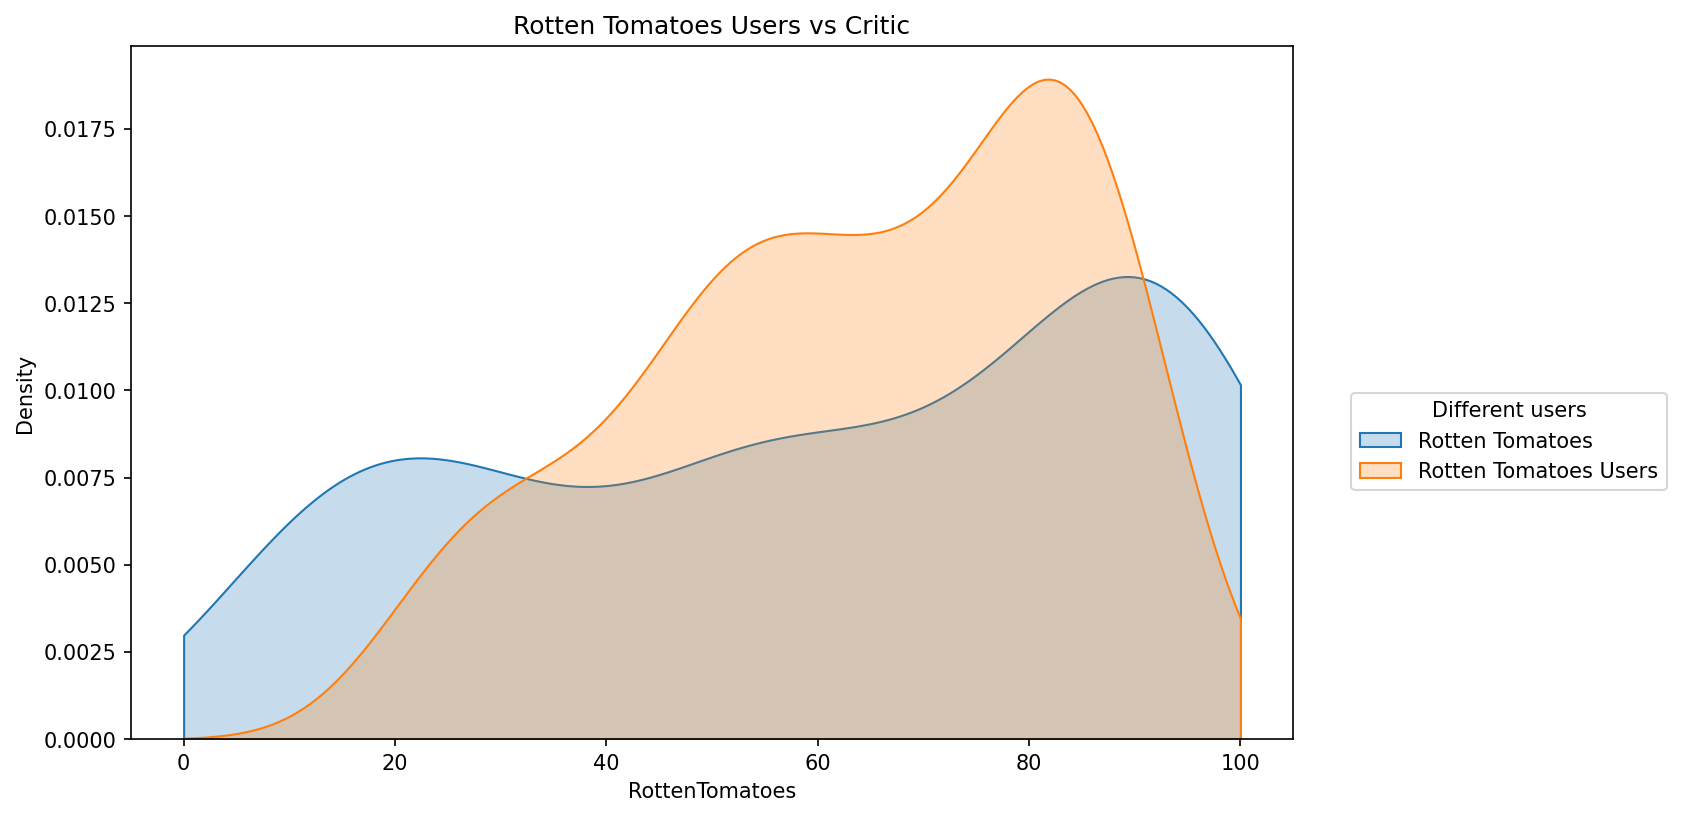

In [16]:
# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=150)

# Create plot
sns.kdeplot(data=all_sites,
            x='RottenTomatoes',
            fill=True,
            label="Rotten Tomatoes",
            clip=[0, 100])

sns.kdeplot(data=all_sites,
            x='RottenTomatoes_User',
            fill=True,
            label="Rotten Tomatoes Users",
            clip=[0, 100])


# Include legends
plt.legend(bbox_to_anchor=(1.05, 0.5),
           loc=2,
           borderaxespad=0.,
           title='Different users')

# Include title
plt.title("Rotten Tomatoes Users vs Critic")

# Show plot
plt.show()

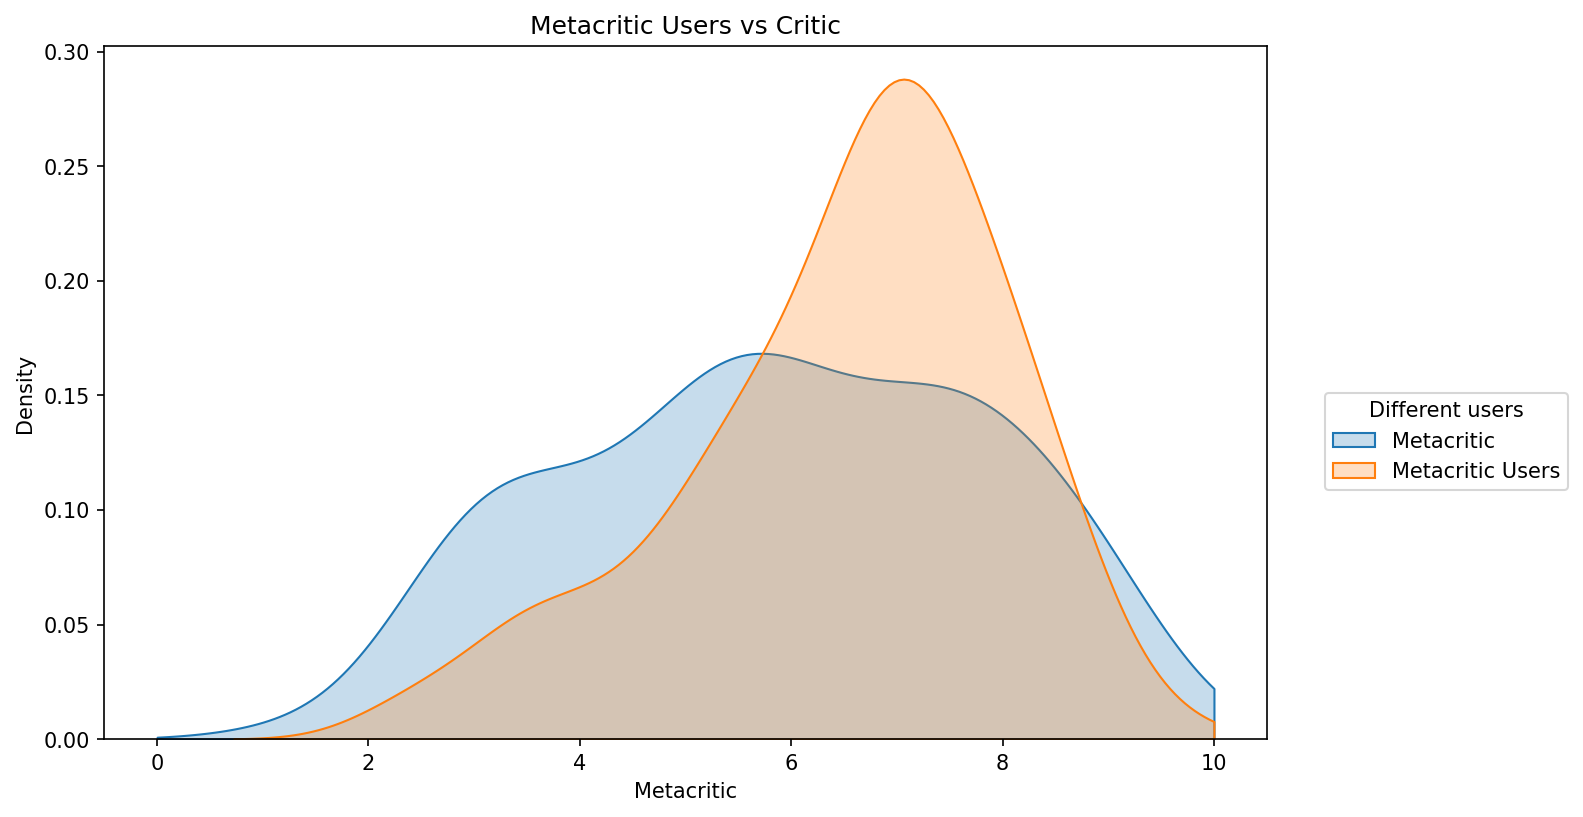

In [17]:
# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=150)


# Create plot
# The Metacritic score was scaled to match the Metacritic user score
sns.kdeplot(x=all_sites['Metacritic']/10,
            fill=True,
            label="Metacritic",
            clip=[0, 10])

sns.kdeplot(data=all_sites,
            x='Metacritic_User',
            fill=True,
            label="Metacritic Users",
            clip=[0, 10])


# Include legends
plt.legend(bbox_to_anchor=(1.05, 0.5),
           loc=2,
           borderaxespad=0.,
           title='Different users')

# Include title
plt.title("Metacritic Users vs Critic")

# Show plot
plt.show()

In both cases, the user score tends to have less variance, which is expected from the fact that the standard deviation of the user's score is generically lesser than the critic's score, see previous describe table with statistics.

### 2.2 Fandango (fandango_scrape.csv)

The data file `fandango_scrape.csv` contains the following features.

Column | Definiton
--- | ---------
FILM | The movie
STARS | Number of stars presented on Fandango.com
RATING |  The Fandango ratingValue for the film, as pulled from the HTML of each page. This is the actual average score the movie obtained.
VOTES | number of people who had reviewed the film at the time we pulled it.

Again, we can see some general information using `head` and `info`.

In [18]:
fandango.head()

,FILM,STARS,RATING,VOTES
0,Fifty Shades of Grey (2015),4.0,3.9,34846
1,Jurassic World (2015),4.5,4.5,34390
2,American Sniper (2015),5.0,4.8,34085
3,Furious 7 (2015),5.0,4.8,33538
4,Inside Out (2015),4.5,4.5,15749


In [19]:
fandango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FILM    504 non-null    object 
 1   STARS   504 non-null    float64
 2   RATING  504 non-null    float64
 3   VOTES   504 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 15.9+ KB


The dataset also appears to be consistent, with no null entries. The method `describe` allows getting general descriptive statistics, as in the previous section.

In [12]:
fandango.describe().transpose().round(1)

,count,mean,std,min,25%,50%,75%,max
STARS,504.0,3.6,1.6,0.0,3.5,4.0,4.5,5.0
RATING,504.0,3.4,1.5,0.0,3.1,3.8,4.3,5.0
VOTES,504.0,1147.9,3830.6,0.0,3.0,18.5,189.8,34846.0


We can see that the mean of both metrics is slightly different. To see if this is expected or not, we can construct some data points from the normal distribution and compare them with its rounded approximation. This is done in the next plot.

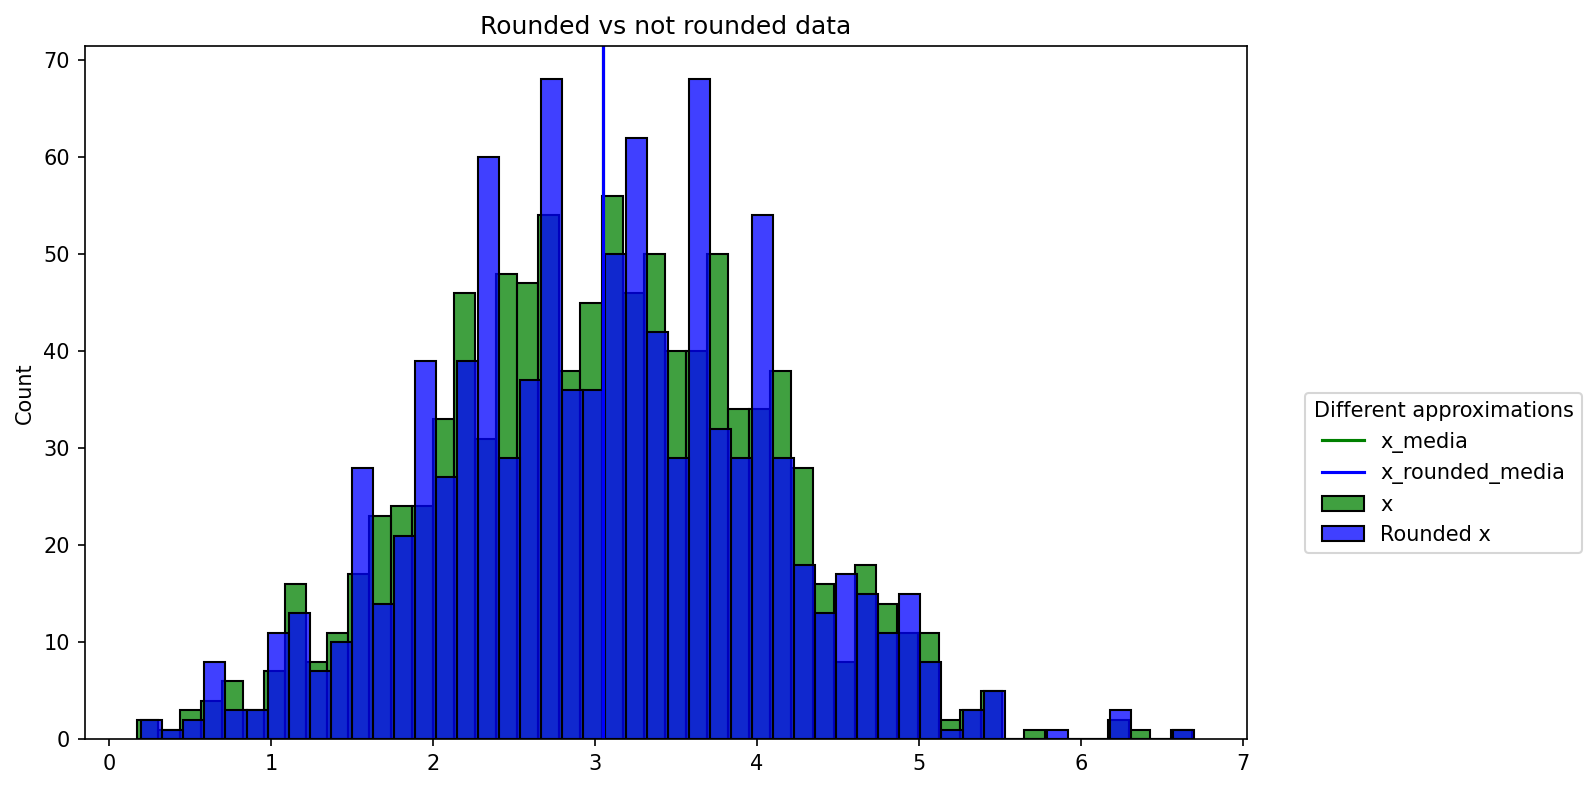

In [13]:
# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=150)

# Generate data
x = 3+np.random.randn(1000)
x_media = np.mean(x)

x_rounded = np.round(x, 1)
x_rounded_media = np.mean(x_rounded)

# Create plot
sns.histplot(x,
             bins=50,
             label="x",
             color="green")
plt.axvline(x_media,
            c='green',
            label="x_media")

sns.histplot(x_rounded,
             bins=50,
             label="Rounded x",
             color="blue")
plt.axvline(x_rounded_media,
            c='blue',
            label="x_rounded_media")

# Include legends
plt.legend(bbox_to_anchor=(1.05, 0.5),
           loc=2,
           borderaxespad=0.,
           title='Different approximations')

# Include title
plt.title("Rounded vs not rounded data")

# Show plot
plt.show()

As we can see, the median is the same after we rounded the numbers. This is an indication that the approximation process in the Fandango score is skewed. We will explore this point in the coming sections.

As was done in the previous section, we can inspect the number of votes for the user score.

In [14]:
features = ["VOTES"]
fandango[features].describe().transpose().round(1)

,count,mean,std,min,25%,50%,75%,max
VOTES,504.0,1147.9,3830.6,0.0,3.0,18.5,189.8,34846.0


Here we see that there are movies with zero votes. Using the same method `nsmallest` we can inspect some of them.

In [15]:
fandango.nsmallest(10, columns = "VOTES")[['FILM',"VOTES","STARS","RATING"]]

,FILM,VOTES,STARS,RATING
435,6 Years (2015),0,0.0,0.0
436,7 Minutes (2015),0,0.0,0.0
437,A Year in Champagne (2015),0,0.0,0.0
438,Balls Out (2015),0,0.0,0.0
439,Before I Wake (2015),0,0.0,0.0
440,Big Significant Things (2015),0,0.0,0.0
441,Caprice (2015),0,0.0,0.0
442,Cas d&#233;sesp&#233;r&#233; (2015),0,0.0,0.0
443,Chagall Malevich (2015),0,0.0,0.0
444,Coffee Bloom (2015),0,0.0,0.0


and the total number is

In [16]:
fandango[fandango["VOTES"] == 0]["FILM"].count()

69

Those data points will not contribute to the final analysis since they do not have information on Fandango rating system. We will treat this matter in the data cleaning and featuring section.

Next, we inspect the correlation between the scores.

In [20]:
fandango[["STARS","RATING"]].corr().round(2)

,STARS,RATING
STARS,1.00,0.99
RATING,0.99,1.00


The correlation between rating and stars is expected to be high, since the latter is an approximation of the former.

Some remarks can be made here. Differently from the previous scoring methods, Fandango uses numbers in the range of 0 to 5, with a minimal increment of 0.1, to score the movies. Furthermore, the values for the STARS rating only show values between 0 and 5 in 0.5 increments (see the unique values below).

In [21]:
fandango["STARS"].unique()

array([4. , 4.5, 5. , 3.5, 3. , 2.5, 2. , 1. , 0. ])

In [22]:
fandango["RATING"].unique()

array([3.9, 4.5, 4.8, 4.3, 4.2, 4. , 3.4, 4.1, 4.4, 3.7, 4.6, 2.7, 3.3,
       3.8, 3.5, 3.6, 2.8, 3.1, 2.9, 3. , 3.2, 4.9, 4.7, 2.3, 2.6, 5. ,
       1.5, 2.5, 2. , 1. , 0. ])

This indicates that an approximation is done to compute the STARS score using the RATING score. We can further explore this by graphing the KDE of both scores.

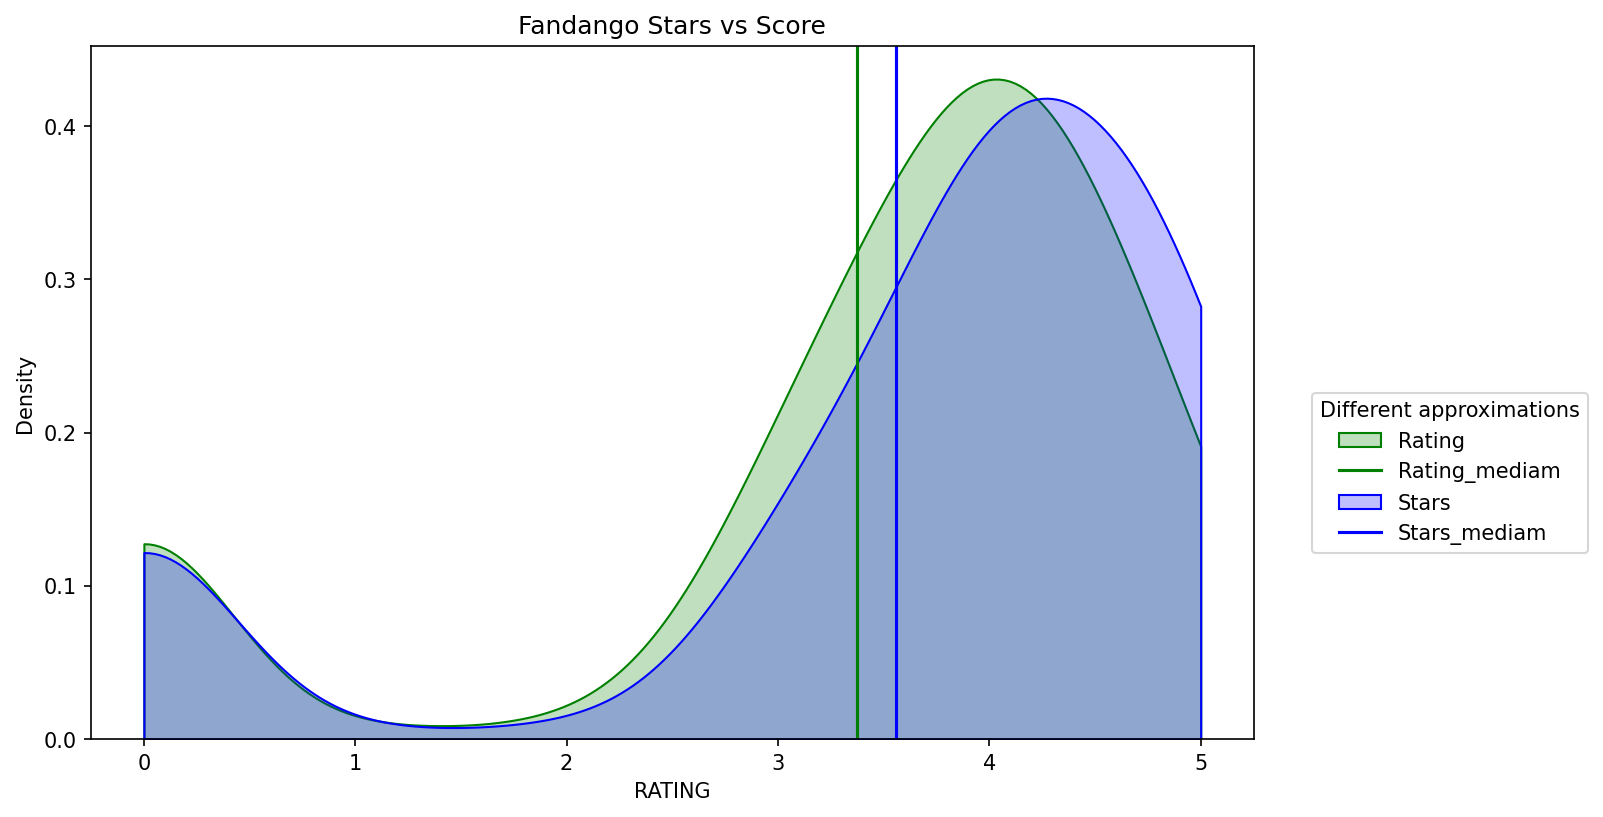

In [23]:
# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=150)

# Compute medians
rating_mediam = fandango["RATING"].mean()
stars_mediam = fandango["STARS"].mean()

# Create plot
sns.kdeplot(data=fandango,
            x='RATING',
            clip=[0, 5],
            fill=True,
            label="Rating",
            color="green")
plt.axvline(rating_mediam,
            c='green',
            label="Rating_mediam")

sns.kdeplot(data=fandango,
            x='STARS',
            clip=[0, 5],
            fill=True,
            label="Stars",
            color="blue")
plt.axvline(stars_mediam,
            c='blue',
            label="Stars_mediam")

# Include legends
plt.legend(bbox_to_anchor=(1.05, 0.5),
           loc=2,
           borderaxespad=0.,
           title='Different approximations')

# Include title
plt.title("Fandango Stars vs Score")

# Show plot
plt.show()

This plot cannot be interpreted as the previous cases (users versus site critics) because here both features represent (in theory) the same value. The stars are expected to be the round value of the rating, and, as we saw previously, the rounded media should be close to the not-rounded media. The visible shift in the star KDE indicates that this round somehow shifts the median of the score. We will come back to this point in the data analysis section.

## 3. Data Cleaning and featuring

In this section, I will reorganize the data and create new features that will be used in the next section to visualize the desired comparisons.

### 3.1 Join all sites data

In this first subsection, I will merge both databases. This will simplify future featuring and comparative analysis. Not every movie in the Fandango dataset is in the All Sites table, and we only want to compare movies that are in both datasets. This indicates that an inner join (based on FILM columns) is most appropriate, since it only considers movies that are in both data frames.

In [24]:
# Merge using inner join
df = pd.merge(fandango,all_sites,on='FILM',how='inner')

# Rename the features
col_rename = {"STARS": "Fandango_stars", "RATING": "Fandango_rating", "VOTES": "Fandango_user_vote_count"}
df = df.rename(columns=col_rename)

# Reorder the features
df = df[['FILM', 'Fandango_stars', 'Fandango_rating',
       'RottenTomatoes', 'RottenTomatoes_User', 'Metacritic',
       'Metacritic_User', 'IMDB', 'Fandango_user_vote_count', 'Metacritic_user_vote_count',
       'IMDB_user_vote_count']]

In [25]:
df.head()

,FILM,Fandango_stars,Fandango_rating,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_user_vote_count,Metacritic_user_vote_count,IMDB_user_vote_count
0,Fifty Shades of Grey (2015),4.0,3.9,25,42,46,3.2,4.2,34846,778,179506
1,Jurassic World (2015),4.5,4.5,71,81,59,7.0,7.3,34390,1281,241807
2,American Sniper (2015),5.0,4.8,72,85,72,6.6,7.4,34085,850,251856
3,Furious 7 (2015),5.0,4.8,81,84,67,6.8,7.4,33538,764,207211
4,Inside Out (2015),4.5,4.5,98,90,94,8.9,8.6,15749,807,96252


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        145 non-null    object 
 1   Fandango_stars              145 non-null    float64
 2   Fandango_rating             145 non-null    float64
 3   RottenTomatoes              145 non-null    int64  
 4   RottenTomatoes_User         145 non-null    int64  
 5   Metacritic                  145 non-null    int64  
 6   Metacritic_User             145 non-null    float64
 7   IMDB                        145 non-null    float64
 8   Fandango_user_vote_count    145 non-null    int64  
 9   Metacritic_user_vote_count  145 non-null    int64  
 10  IMDB_user_vote_count        145 non-null    int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 13.6+ KB


Of the initial 146 movies in the `all_sites_scores.csv` and of the 504 movies in `fandango_scrape.csv` only 145 have a match in both dataset. 

### 3.2 Year feature

The movie name contains the year of the movie in the form

    Film Title Name (Year)

We can extract this information and create a new feature called YEAR to simplify the quantification.

In [27]:
# Create YEAR feature from movie name
df["YEAR"] = df["FILM"].apply(lambda x: x.split()[-1][-5:-1])

In [28]:
df[["FILM","YEAR"]].head()

,FILM,YEAR
0,Fifty Shades of Grey (2015),2015
1,Jurassic World (2015),2015
2,American Sniper (2015),2015
3,Furious 7 (2015),2015
4,Inside Out (2015),2015


This allows to count the number of movies per year in the dataset.

In [29]:
df["YEAR"].value_counts()

2015    128
2014     17
Name: YEAR, dtype: int64

### 3.3 Remove movies with few votes

The process of joining the two dataset eliminated the movies with scores lesser than 35 on Fandango voter count.

In [30]:
df[["Fandango_user_vote_count","Metacritic_user_vote_count", "IMDB_user_vote_count"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Fandango_user_vote_count,145.0,3817.696552,6368.668671,35.0,218.0,1430.0,4279.0,34846.0
Metacritic_user_vote_count,145.0,184.489655,317.361740,4.0,33.0,72.0,167.0,2375.0
IMDB_user_vote_count,145.0,42572.186207,67558.506121,243.0,5626.0,18986.0,44711.0,334164.0


But we still have movies with small Metacritic voter count.

In [31]:
df.nsmallest(10, columns = "Metacritic_user_vote_count")[['FILM',"Metacritic_user_vote_count","IMDB_user_vote_count"]]

,FILM,Metacritic_user_vote_count,IMDB_user_vote_count
139,Seymour: An Introduction (2015),4,243
142,The Wrecking Crew (2015),4,732
109,The Vatican Tapes (2015),5,952
127,The 100-Year-Old Man Who Climbed Out the Windo...,5,17237
121,5 Flights Up (2015),6,2174
132,The Stanford Prison Experiment (2015),6,950
138,The Hunting Ground (2015),6,1196
99,Spare Parts (2015),7,47377
120,A Little Chaos (2015),7,4778
134,Escobar: Paradise Lost (2015),7,7819


We can see that although those movies have few votes on Metacritic the number of votes on IMDB is high (the minimum number of votes on IMDB is 243), meaning that we still have reliable information on the movie score. Those movies will be kept for future analysis.

### 3.4 Normalization (scale the all ratings)

Most scores are in different ranges; it is a problem to compare them in the same visualization. We will normalize all data to the smallest scale (0–5 rating).

In [32]:
# Check if data is rescaled
if all(df[['IMDB', 'RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User']].max() >= 5):
    # Scale by 20
    df['RottenTomatoes'] = np.round(df['RottenTomatoes']/20, 1)
    df['RottenTomatoes_User'] = np.round(df['RottenTomatoes_User']/20, 1)
    df['Metacritic'] = np.round(df['Metacritic']/20, 1)

    # Scale by 2
    df['Metacritic_User'] = np.round(df['Metacritic_User']/2, 1)
    df['IMDB'] = np.round(df['IMDB']/2, 1)
else:
    print("Data already scaled.")
    
df.head()

,FILM,Fandango_stars,Fandango_rating,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_user_vote_count,Metacritic_user_vote_count,IMDB_user_vote_count,YEAR
0,Fifty Shades of Grey (2015),4.0,3.9,1.2,2.1,2.3,1.6,2.1,34846,778,179506,2015
1,Jurassic World (2015),4.5,4.5,3.6,4.0,3.0,3.5,3.6,34390,1281,241807,2015
2,American Sniper (2015),5.0,4.8,3.6,4.2,3.6,3.3,3.7,34085,850,251856,2015
3,Furious 7 (2015),5.0,4.8,4.0,4.2,3.4,3.4,3.7,33538,764,207211,2015
4,Inside Out (2015),4.5,4.5,4.9,4.5,4.7,4.4,4.3,15749,807,96252,2015


Now, all scores are in the same range.

### 3.5 Difference between users and critic in Rotten Tomatoes and Metacritic



The previous featuring allowed us to compute the difference between the user and critic scores for the same website. We will create two new features that will indicate this numeric difference for Rotten Tomatoes and Metacritic (those are the only two who have this information).

In [33]:
# Rotten Tomatoes difference between critic and users
df['Rotten_critic_user_diff'] = (df['RottenTomatoes'] - df['RottenTomatoes_User']).abs()

# Metacritic difference between critic and users
df['Metacritic_critic_user_diff'] = (df['Metacritic'] - df['Metacritic_User']).abs()

In [34]:
df[['Rotten_critic_user_diff', 'Metacritic_critic_user_diff']].head()

,Rotten_critic_user_diff,Metacritic_critic_user_diff
0,0.9,0.7
1,0.4,0.5
2,0.6,0.3
3,0.2,0.0
4,0.4,0.3


In [35]:
df[['Rotten_critic_user_diff', 'Metacritic_critic_user_diff']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rotten_critic_user_diff,145.0,0.755862,0.605516,0.0,0.3,0.6,1.1,3.3
Metacritic_critic_user_diff,145.0,0.599310,0.454987,0.0,0.3,0.5,0.8,2.5


These new features will be analyzed in the last section.

### 3.6 Difference between STARS displayed and RATING in Fandango

In this last subsection, the difference between the star and rating score of Fandango's data will be transformed in a new feature. At this point, it is important to remember that the star rating is meant to be the displaying information, on the Fandango website, of the rating score. Both represent the same information, the user's votes result.

In [36]:
df["Fandango_stars_diff"] = (df['Fandango_stars'] - df['Fandango_rating']).abs()

In [37]:
df["Fandango_stars_diff"].head()

0    0.1
1    0.0
2    0.2
3    0.2
4    0.0
Name: Fandango_stars_diff, dtype: float64

In [38]:
df["Fandango_stars_diff"].describe()

count    145.000000
mean       0.244828
std        0.152721
min        0.000000
25%        0.100000
50%        0.200000
75%        0.400000
max        0.500000
Name: Fandango_stars_diff, dtype: float64

We can see that the difference in the information is as high as 0.5, a high discrepancy for any simple approximation. We will return to this topic in the next section.

### 3.7 Reade data save
Finally, after the data cleaning and featuring process, we can save this data as it is ready to be used in our final analysis.

In [54]:
df.to_csv('data\\ready\\processed_data.csv', index=False)

## 4. Data analysis

This section is dedicated to analyzing the dataset as a whole. No new features will be created here.

### 4.1 Critic vs User score in Rotten Tomatoes and Metacritic

We can inspect the difference between the scores given by users and critics on both Rotten Tomatoes and Metacritic.

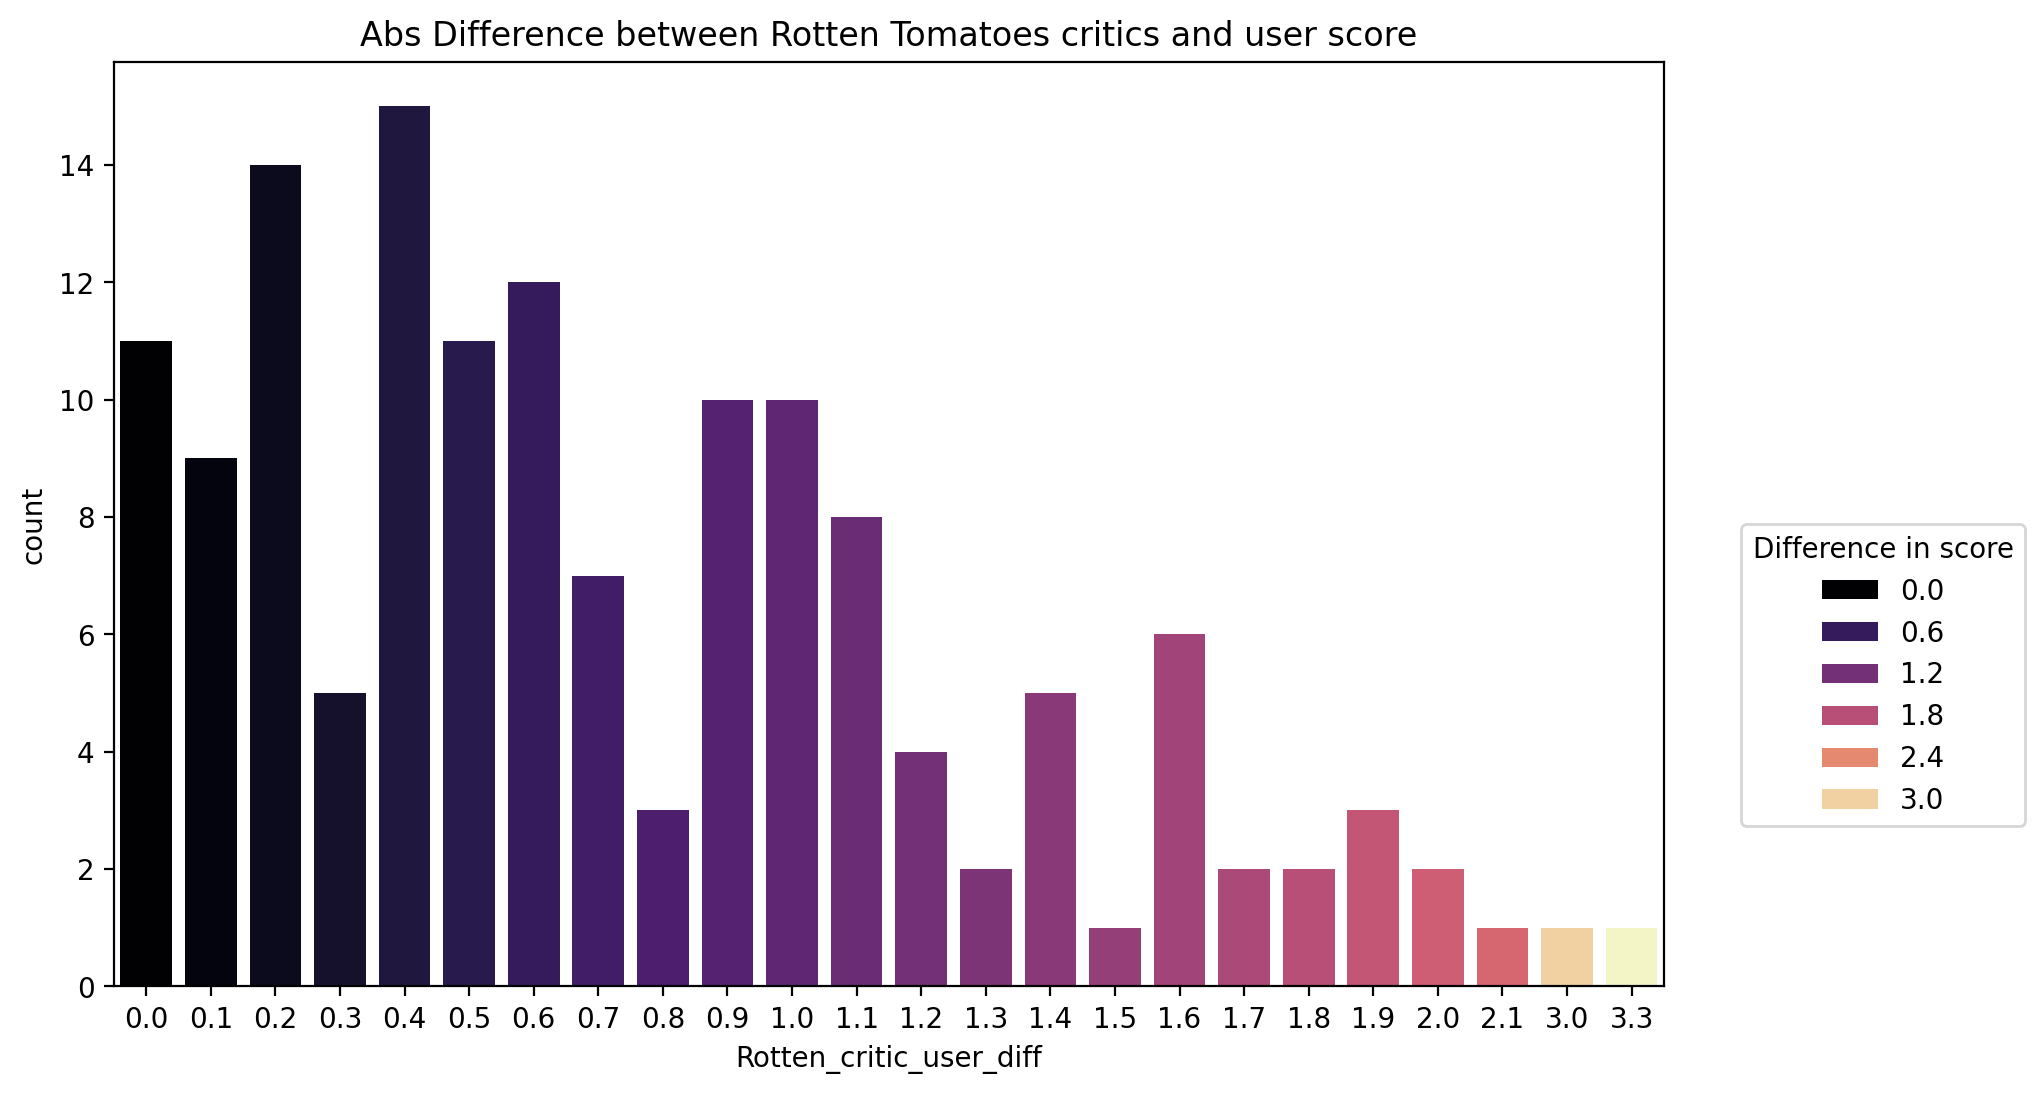

In [55]:
# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=200)

# Create plot
sns.countplot(x=df['Rotten_critic_user_diff'].round(2),
              hue=df['Rotten_critic_user_diff'].round(2),
              palette="magma")

# Include legends
plt.legend(bbox_to_anchor=(1.05, 0.5),
           loc=2,
           borderaxespad=0.,
           title='Difference in score')

# Include title
plt.title("Abs Difference between Rotten Tomatoes critics and user score")

# Show plot
plt.show()

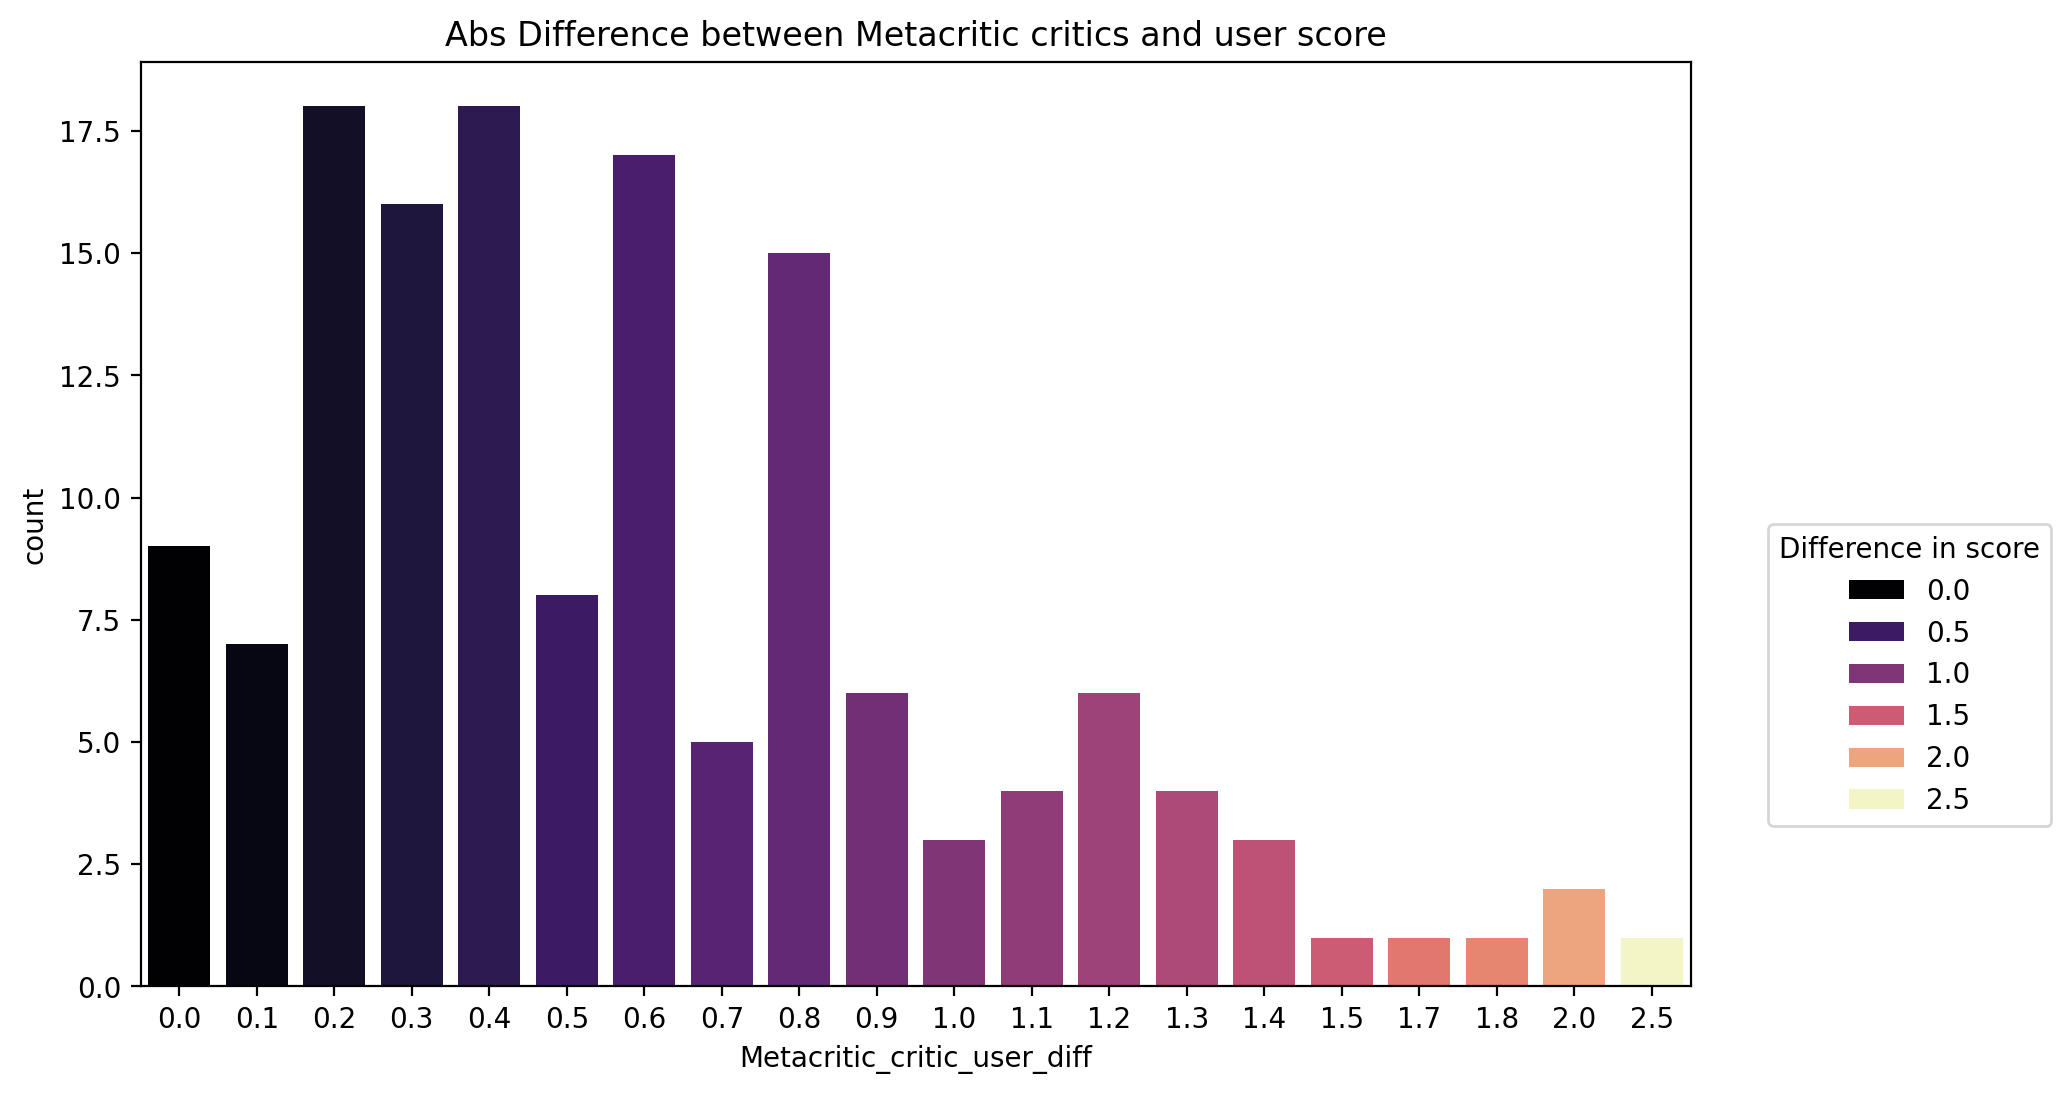

In [56]:
# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=200)

# Create plot
sns.countplot(x=df['Metacritic_critic_user_diff'].round(2),
              hue=df['Metacritic_critic_user_diff'].round(2),
              palette="magma")

# Include legends
plt.legend(bbox_to_anchor=(1.05, 0.5),
           loc=2,
           borderaxespad=0.,
           title='Difference in score')

# Include title
plt.title("Abs Difference between Metacritic critics and user score")

# Show plot
plt.show()

We can see that large differences are less likely to occur. That is, a big difference between critic and user scores is less common. We can inspect some cases where this difference is larger. For the Rotten Tomatoes, we have

In [38]:
df[df['Rotten_critic_user_diff'] >= 2.1][[
    "FILM", 'RottenTomatoes', 'RottenTomatoes_User']]

,FILM,RottenTomatoes,RottenTomatoes_User
67,Do You Believe? (2015),0.9,4.2
89,Little Boy (2015),1.0,4.0
103,Mr. Turner (2014),4.9,2.8


In [39]:
df[df['Metacritic_critic_user_diff'] >= 1.5][[
    "FILM", 'Metacritic', 'Metacritic_User']]

,FILM,Metacritic,Metacritic_User
42,Chappie (2015),2.0,3.7
63,The Gallows (2015),1.5,3.5
65,Black or White (2015),2.2,4.0
73,Self/less (2015),1.7,4.2
89,Little Boy (2015),1.5,3.0
130,Dark Places (2015),2.0,4.0


One movie appears in both lists: Little Boy (2015). We can say that this movie is appreciated more by users than critics, since the critic score is lower. Again, this discrepancy is not unusual. Both views are from distinct backgrounds; there is no supposition that they would agree with the movie score. Even in this case, the discrepancy is not quite so significant.

### 4.2 Comparing user score between all sites
Now we will compare all user-informed scores on all sites. We have two objectives here: Evaluate if the user scores are consistent across all sites; and evaluate if the displayed star score on Fandango (which should be an approximation of its user score) appears to be artificially skewed.

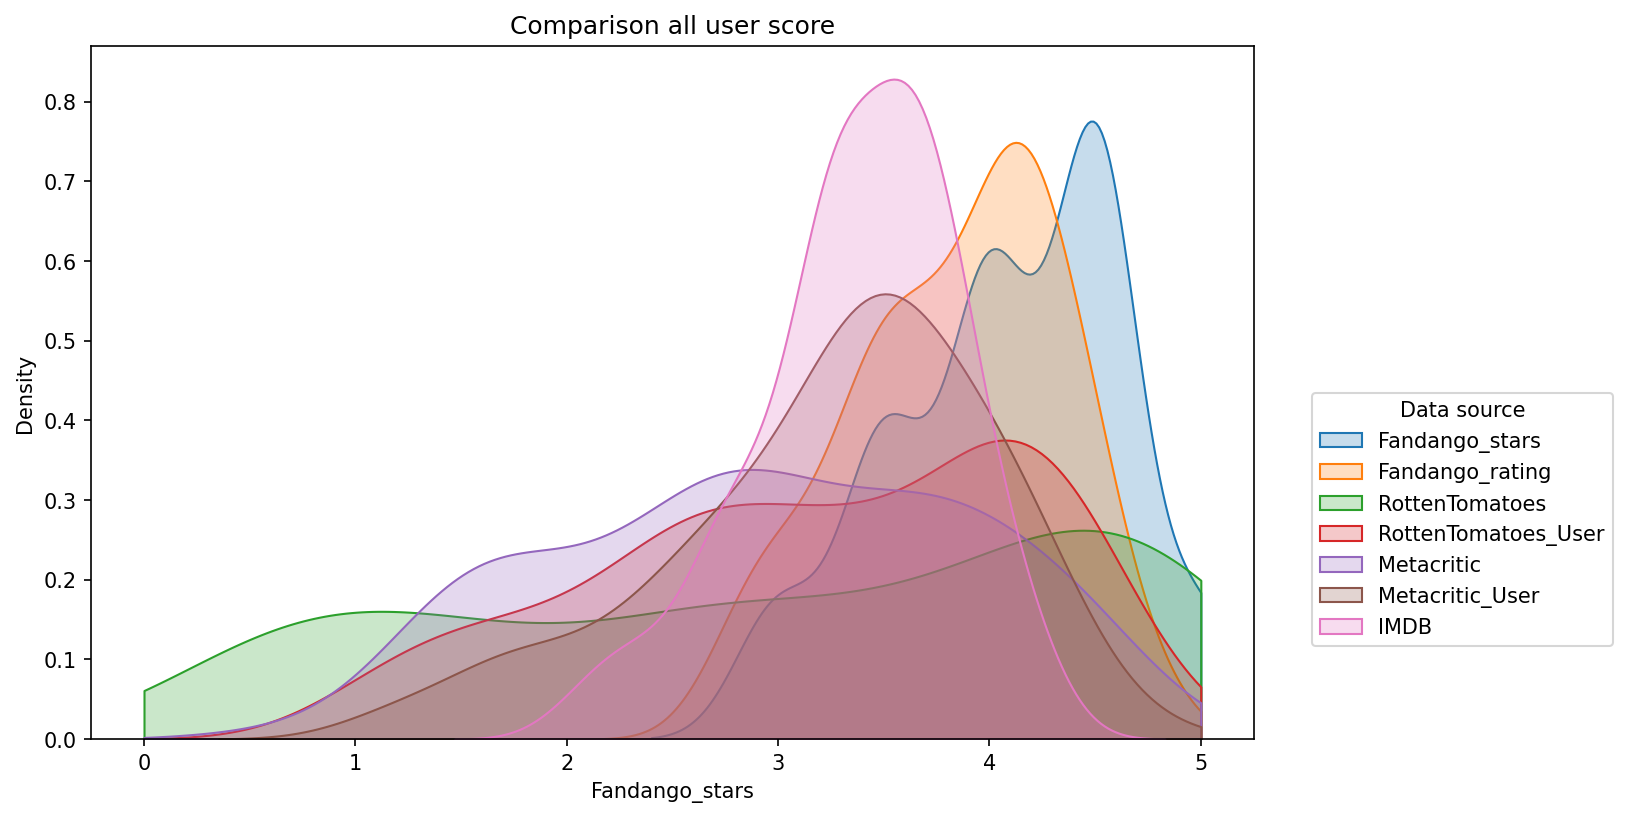

In [57]:
# Df columns with ratings
target_columns = ["Fandango_stars", "Fandango_rating", "RottenTomatoes",
                  "RottenTomatoes_User", "Metacritic", "Metacritic_User", "IMDB"]

# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=150)

# Create plots
for column in target_columns:
    sns.kdeplot(data=df,
                x=column,
                clip=[0, 5],
                fill=True,
                label=str(column))


# Include legends
plt.legend(bbox_to_anchor=(1.05, 0.5),
           loc=2,
           borderaxespad=0.,
           title='Data source')

# Include title
plt.title("Comparison all user score")

# Show plot
plt.show()

We can see that Fandango has a skewed distribution to the right. That is, their scores are biased toward higher values. This is the same result that we observed when we compared their rating and star values. We can do a silly test to see if a usual approximation would create this kind of behavior.

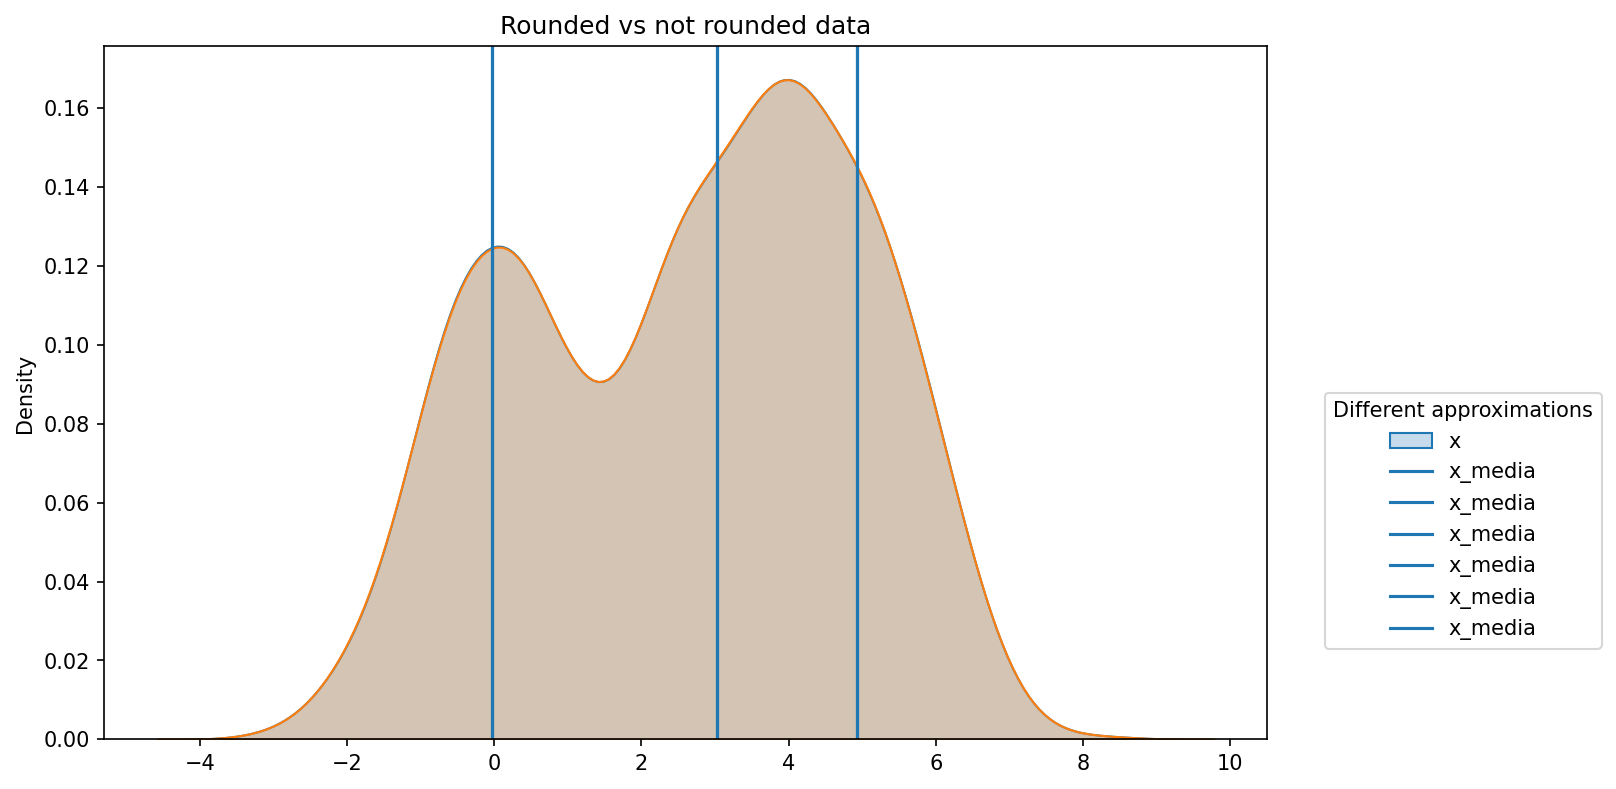

In [41]:
# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=150)

# Generate data
data_mean_0 = 0 + np.random.randn(1000)
data_mean_3 = 3 + np.random.randn(1000)
data_mean_5 = 5 + np.random.randn(1000)

mean_0 = np.mean(data_mean_0)
mean_3 = np.mean(data_mean_3)
mean_5 = np.mean(data_mean_5)

x = np.concatenate((data_mean_0,data_mean_3,data_mean_5), axis=None)

data_mean_0_rounded = np.round(data_mean_0, 1)
data_mean_3_rounded = np.round(data_mean_3, 1)
data_mean_5_rounded = np.round(data_mean_5, 1)

mean_0_rounded = np.mean(data_mean_0_rounded)
mean_3_rounded = np.mean(data_mean_3_rounded)
mean_5_rounded = np.mean(data_mean_5_rounded)

x_rounded = np.concatenate(
    (data_mean_0_rounded, data_mean_3_rounded, data_mean_5_rounded), axis=None)


# Create plots
sns.kdeplot(x,
            clip=[-10, 10],
            fill=True,
             label="x")
for mean_value in [mean_0, mean_3, mean_5]:
    plt.axvline(mean_value,
            label="x_media")

sns.kdeplot(x_rounded,
            clip=[-10, 10],
            fill=True)
for mean_value in [mean_0_rounded, mean_3_rounded, mean_5_rounded]:
    plt.axvline(mean_value,
                label="x_media")

# Include legends
plt.legend(bbox_to_anchor=(1.05, 0.5),
           loc=2,
           borderaxespad=0.,
           title='Different approximations')

# Include title
plt.title("Rounded vs not rounded data")

# Show plot
plt.show()

In the previous plot, we created data using three “standard normal” distributions around points 0, 3 and 5. We also created a rounded approximation to one decimal place and finally plotted all this data and the median of each point. We can see that the approximation does not skew the distribution as expected. This indicates that the approximation method used by the Fandango website probably created this bias artificially, since we saw that this outcome was not expected in a simple rounding process.

A final comparison can be made using a cluster map visualization. 

<Figure size 1500x900 with 0 Axes>

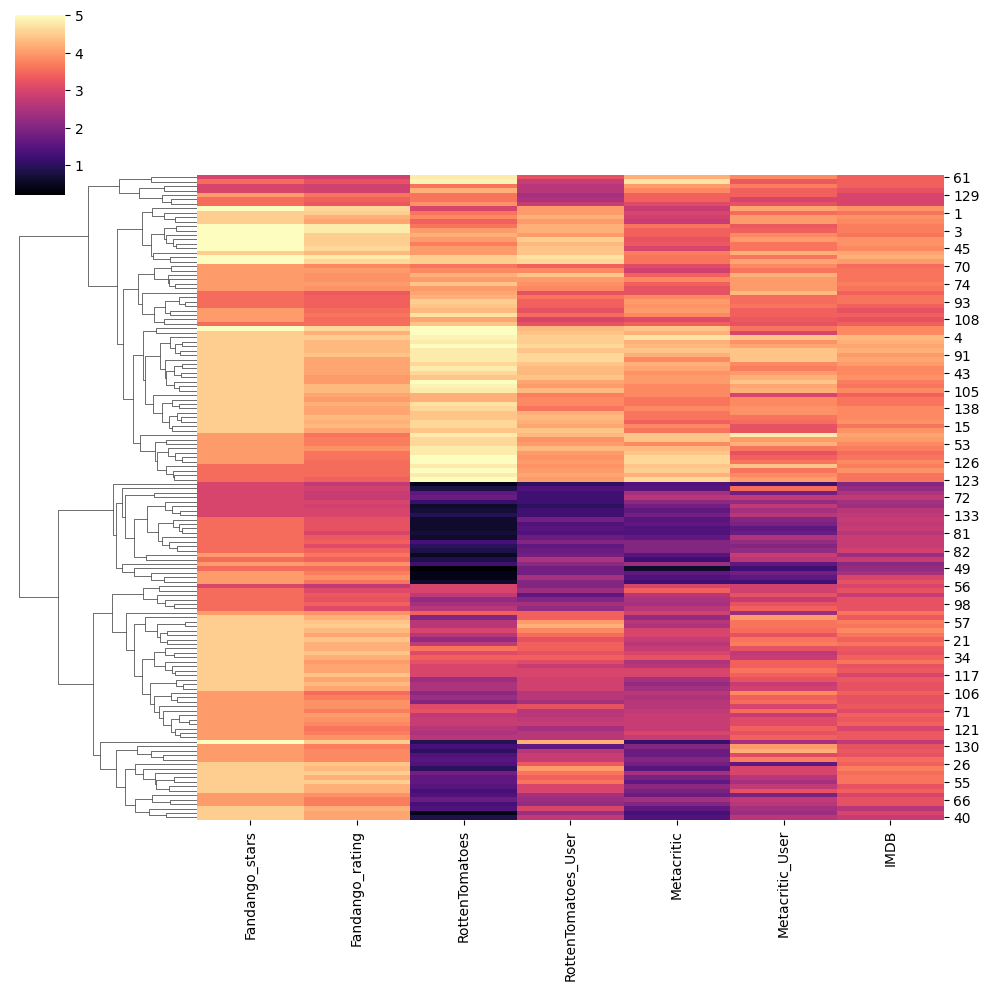

In [42]:
# Df columns with ratings
target_columns = ["Fandango_stars", "Fandango_rating", "RottenTomatoes",
                  "RottenTomatoes_User", "Metacritic", "Metacritic_User", "IMDB"]

# Define figure dimensions
plt.figure(figsize=(10, 6), dpi=150)

# Create plots
sns.clustermap(df[target_columns],
               cmap="magma",
               col_cluster=False)

# Show plot
plt.show()

The difference in color between START and RATING (both from Fandango) and the other websites visually indicates that the scores are discrepancy as expected from the previous KDE plot. This is the same skewness to higher values that was observed.

This is the final result; these artificially high values are not explained by approximation, since we saw that this approximation process does not introduce bias in the data. The most probable cause, given that we include other factors such as the business model of the website, is that this artificial increase in scores is economically interesting to make the user buy the movie ticket, hoping that the movie is good. 

As a final point, we can see which movie has the lowest score on other sites and the largest difference in displayed score on Fandango.

In [43]:
target_columns = ["Fandango_stars", "Fandango_rating", "RottenTomatoes",
                  "RottenTomatoes_User", "Metacritic", "Metacritic_User", "IMDB"]

# The minimum score is in RottenTomatoes
df[target_columns].min()

Fandango_stars         3.0
Fandango_rating        2.7
RottenTomatoes         0.2
RottenTomatoes_User    1.0
Metacritic             0.6
Metacritic_User        1.2
IMDB                   2.0
dtype: float64

In [44]:
df[df["RottenTomatoes"] == 0.2].nlargest(
    10, 'Fandango_stars_diff')[target_columns]

,Fandango_stars,Fandango_rating,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB
49,3.5,3.5,0.2,1.8,0.6,1.2,2.2


In [45]:
df.iloc[49]

FILM                           Paul Blart: Mall Cop 2 (2015)
Fandango_stars                                           3.5
Fandango_rating                                          3.5
RottenTomatoes                                           0.2
RottenTomatoes_User                                      1.8
Metacritic                                               0.6
Metacritic_User                                          1.2
IMDB                                                     2.2
Fandango_user_vote_count                                3054
Metacritic_user_vote_count                               211
IMDB_user_vote_count                                   15004
YEAR                                                    2015
Rotten_critic_user_diff                                  1.6
Metacritic_critic_user_diff                              0.6
Fandango_stars_diff                                      0.0
Name: 49, dtype: object

In [46]:
target_columns = ["RottenTomatoes",
                  "RottenTomatoes_User", "Metacritic", "Metacritic_User", "IMDB"]
# Mean on other sites
df.iloc[49][target_columns].mean()

1.2

The movie "Paul Blart: Mall Cop 2 (2015)" has a Fandango score of 3.5, and the media score across all other sites is 1.2. This is clearly a bad movie with an average score in Fandango.